In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# machine learning
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab 
import scipy.stats as stats


# jupyter sugar
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
%matplotlib inline

# Load data

In [3]:
boston = load_boston()

In [4]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
data = pd.DataFrame(boston.data, columns=boston.feature_names)

In [6]:
data['MDEV'] = boston.target

In [7]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MDEV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [9]:
data.to_csv('boston.csv', index=False)

# Data exploration

In [10]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MDEV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [11]:
features = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT'
]

## Pairplot of features

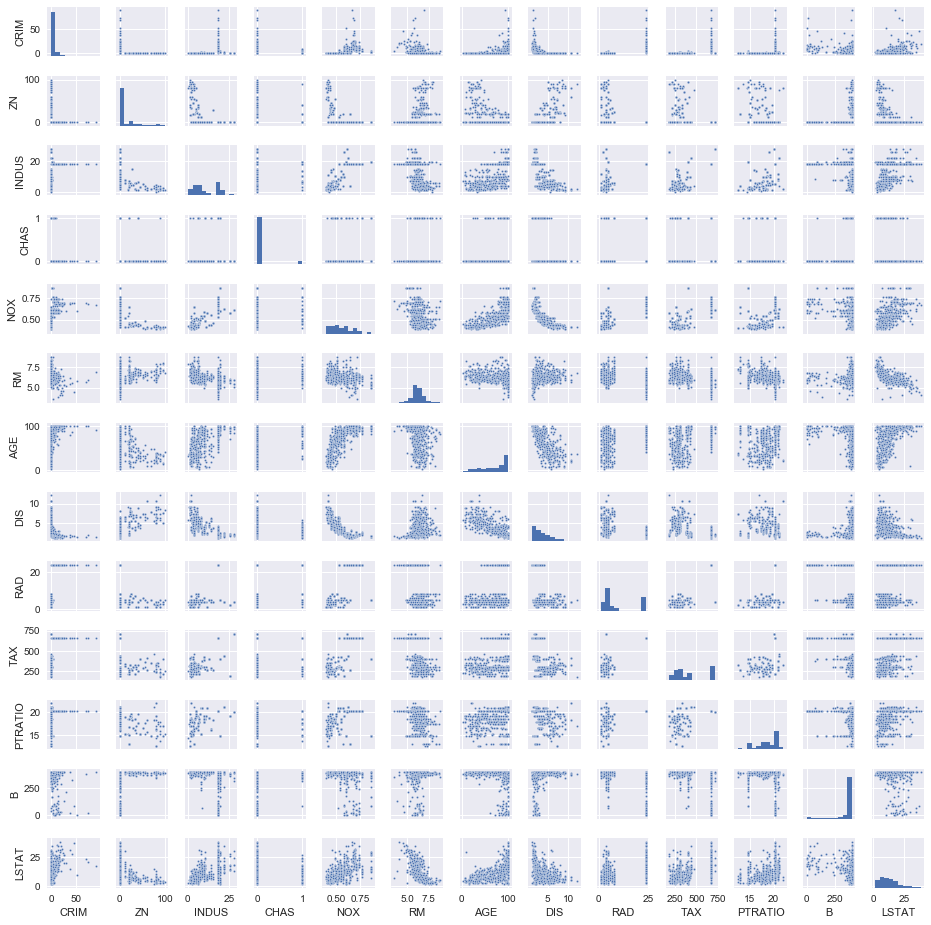

In [12]:
sns.pairplot(
    data=data,
    vars=features,
    size=1,
    plot_kws={'s': 5}
);

## Correlation plot of features

In [13]:
corr = data[features].corr()

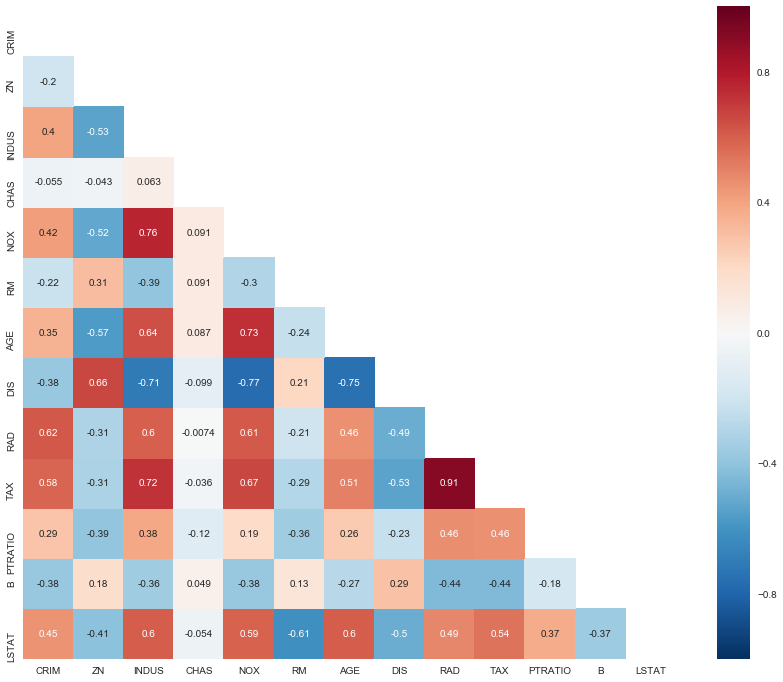

In [14]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15, 12));
    
    sns.heatmap(
        corr,
        ax=ax,
        annot=True,
        mask=mask,
        square=True
    );

We can see that `RAD` and `TAX` are highly corelated. When we fit a regression model, we will leave one of these out.

## Histogram of `MDEV`

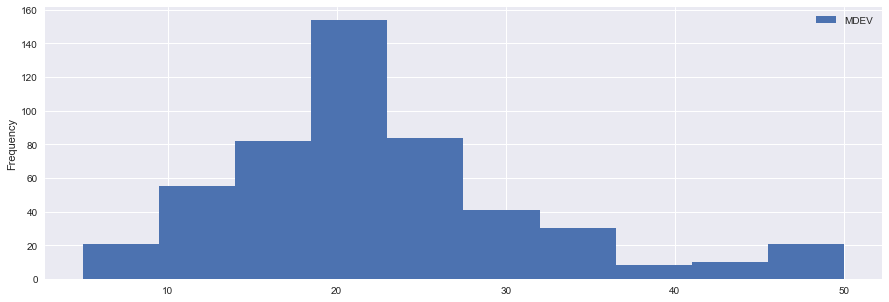

In [15]:
data[['MDEV']].plot(
    kind='hist',
    figsize=(15, 5),
    bins=10
);

Right skewed distribution of `MDEV` values suggest a `log` transfrom may be appropriate.

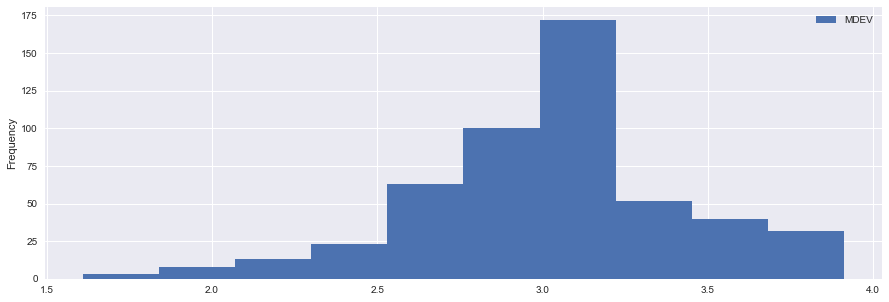

In [16]:
np.log(data[['MDEV']]).plot(
    kind='hist',
    figsize=(15, 5),
    bins=10
);

This looks more normally distributed, so we will try fiting the model to predict `log(MDEV)`

# Model

### Remove `RAD` from features

In [17]:
reduced_features = [f for f in features if f != 'RAD']

In [18]:
# split data into train and test set
# transform mdev values with log
X_train, X_test, y_train, y_test = train_test_split(
    data[reduced_features].values,
    np.log(data['MDEV'].values),
    test_size=0.2
)

# add constant
X_trainc = sm.add_constant(X_train)

# initialize model
reg = sm.OLS(y_train, X_trainc)

# fit model
fit = reg.fit()

# model summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     113.3
Date:                Sat, 20 May 2017   Prob (F-statistic):          3.86e-119
Time:                        16:32:45   Log-Likelihood:                 95.186
No. Observations:                 404   AIC:                            -164.4
Df Residuals:                     391   BIC:                            -112.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7642      0.224     16.829      0.000       3.324       4.204
x1            -0.0096      0.001     -6.440      0.000      -0.013      -0.007
x2             0.0006      0.001      0.890      0.374      -0.001       0.002
x3            -0.0017      0.003     -0.609      0.543      -0.007       0.004
x4             0.1220      0.040      3.079      0.002       0.044       0.200
x5            -0.5850      0.176     -3.322      0.001      -0.931      -0.239
x6             0.1012      0.019      5.343      0.000       0.064       0.138
x7             0.0003      0.001      0.455      0.650      -0.001       0.001
x8            -0.0424      0.009     -4.752      0.000      -0.060      -0.025
x9          5.188e-05      0.000      0.486      0.628      -0.000       0.000
x10           -0.0333      0.006     -5.741      0.000      -0.045      -0.022
x11            0.0004      0.000      2.747      0.006       0.000       0.001
x12           -0.0310      0.002    -13.626      0.000      -0.035      -0.027
==============================================================================
Omnibus:                       51.132   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.558
Skew:                           0.458   Prob(JB):                     5.15e-46
Kurtosis:                       6.398   Cond. No.                     1.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
print(features[1],features[2],features[6],features[8])

ZN INDUS AGE RAD


The features `ZN`, `INDUS`, and `AGE`, `RAD` have `p`-values that suggest they are not significant in predicting `MDEV`, so we will remove them.

In [20]:
reduced_features = [f for f in features if f not in ['ZN', 'INDUS', 'AGE', 'INDUS', 'RAD']]

## Train model on reduced features

In [21]:
# split data into train and test set
# transform mdev values with log
X_train, X_test, y_train, y_test = train_test_split(
    data[reduced_features].values,
    np.log(data['MDEV'].values),
    test_size=0.2
)

# add constant
X_trainc = sm.add_constant(X_train)

# initialize model
reg = sm.OLS(y_train, X_trainc)

# fit model
fit = reg.fit()

# model summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     164.4
Date:                Sat, 20 May 2017   Prob (F-statistic):          1.65e-127
Time:                        16:32:47   Log-Likelihood:                 108.37
No. Observations:                 404   AIC:                            -196.7
Df Residuals:                     394   BIC:                            -156.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8918      0.227     17.141      0.000       3.445       4.338
x1            -0.0080      0.001     -5.921      0.000      -0.011      -0.005
x2             0.1296      0.036      3.630      0.000       0.059       0.200
x3            -0.7292      0.154     -4.732      0.000      -1.032      -0.426
x4             0.0981      0.018      5.500      0.000       0.063       0.133
x5            -0.0433      0.007     -6.160      0.000      -0.057      -0.029
x6          3.726e-05   9.38e-05      0.397      0.691      -0.000       0.000
x7            -0.0369      0.005     -6.938      0.000      -0.047      -0.026
x8             0.0004      0.000      3.493      0.001       0.000       0.001
x9            -0.0297      0.002    -13.924      0.000      -0.034      -0.026
==============================================================================
Omnibus:                       35.198   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.466
Skew:                           0.227   Prob(JB):                     1.41e-30
Kurtosis:                       5.821   Cond. No.                     1.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
reduced_features[5]

'TAX'

The feature `TAX` has `p`-value that suggests it is not a significant predictor, so we will remove it.

## Reduce features again

In [23]:
reduced_features = [f for f in reduced_features if f != 'TAX']

In [24]:
# split data into train and test set
# transform mdev values with log
X_train, X_test, y_train, y_test = train_test_split(
    data[reduced_features].values,
    np.log(data['MDEV'].values),
    test_size=0.2
)

# add constant
X_trainc = sm.add_constant(X_train)

# initialize model
reg = sm.OLS(y_train, X_trainc)

# fit model
fit = reg.fit()

# model summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     172.1
Date:                Sat, 20 May 2017   Prob (F-statistic):          1.16e-123
Time:                        16:32:49   Log-Likelihood:                 76.537
No. Observations:                 404   AIC:                            -135.1
Df Residuals:                     395   BIC:                            -99.06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9821      0.223     17.849      0.000       3.544       4.421
x1            -0.0080      0.001     -5.907      0.000      -0.011      -0.005
x2             0.1372      0.042      3.243      0.001       0.054       0.220
x3            -0.6624      0.154     -4.305      0.000      -0.965      -0.360
x4             0.0951      0.018      5.175      0.000       0.059       0.131
x5            -0.0449      0.008     -5.767      0.000      -0.060      -0.030
x6            -0.0379      0.005     -7.162      0.000      -0.048      -0.028
x7             0.0003      0.000      2.291      0.023    4.21e-05       0.001
x8            -0.0305      0.002    -13.609      0.000      -0.035      -0.026
==============================================================================
Omnibus:                       58.458   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.782
Skew:                           0.672   Prob(JB):                     3.69e-37
Kurtosis:                       5.857   Cond. No.                     8.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Test multicollinearity with variance inflation factor

In [25]:
pd.DataFrame(
        data=dict(zip(
        ['intercept']+data[reduced_features].columns.tolist(),
        [variance_inflation_factor(X_trainc, i) for i in range(X_trainc.shape[1])]
    )),
    index=['vif']
)

,B,CHAS,CRIM,DIS,LSTAT,NOX,PTRATIO,RM,intercept
vif,1.296179,1.061055,1.475124,2.665645,2.694248,3.18964,1.25906,1.766683,490.467331


None of the features have `vif` larger than 5, so we will keep all of them.

## Histogram of residuals

In [26]:
# add constant

X_testc = sm.add_constant(X_test)

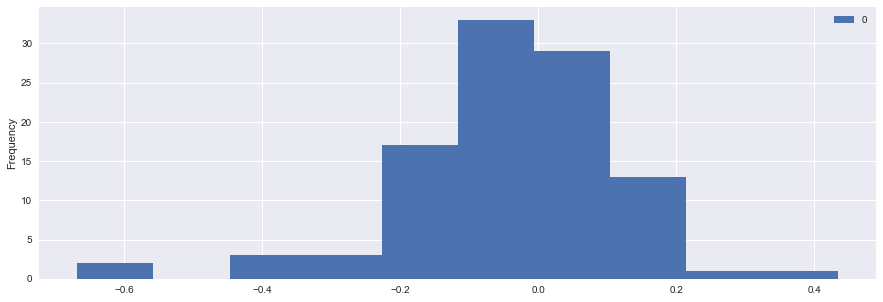

In [27]:
pd.DataFrame(y_test -  fit.predict(X_testc)).plot(
    kind='hist',
    figsize=(15, 5),
    bins=10
);

## Q-Q plot

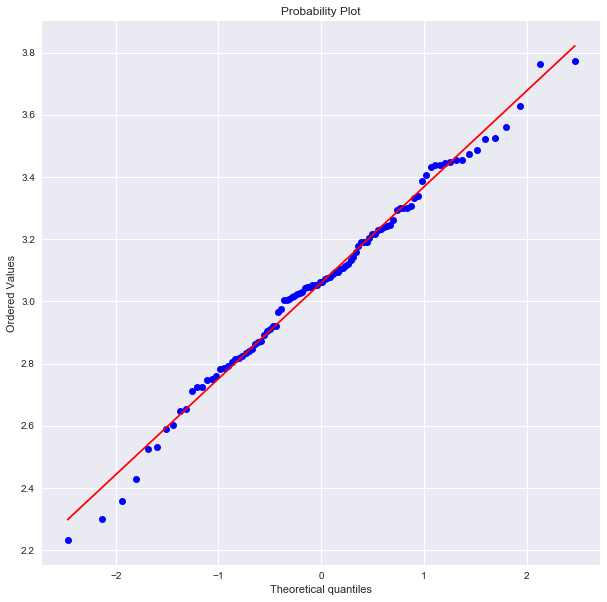

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

stats.probplot(
    x=fit.predict(X_testc), 
    dist="norm", 
    plot=ax
);

## Fitted vs. Residual plot

In [29]:
fitted = fit.predict(X_testc)
residuals = y_test -  fitted

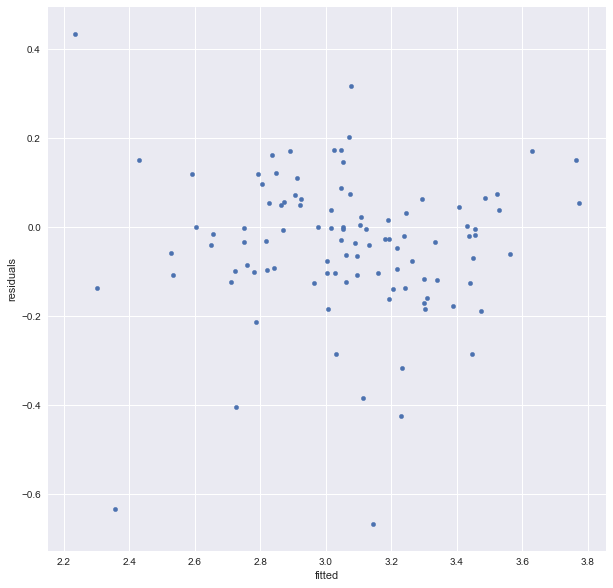

In [30]:
pd.DataFrame(data={
    'residuals': residuals,
    'fitted': fitted
}).plot(
    kind='scatter',
    figsize=(10, 10),
    x='fitted',
    y='residuals'
);